In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sn
import io
import os
import pathlib
import matplotlib.pyplot as plt
import reliability
import dataframe_image as dfi
from datetime import datetime as dt
import itertools
from collections import Counter


path = str(pathlib.Path().absolute())

# FFDA bluegene
## Creazione dataframe bluegene

In [2]:
df_temp = pd.read_csv(path+'/BGLErrorLog.txt', names = ['Original'])
df_temp[['Timestamp', 'Node', 'Card', 'Message']] = df_temp['Original'].str.split(' ', 3, expand=True)
bluegene_df = pd.DataFrame(df_temp[['Timestamp', 'Node', 'Card', 'Message']])
bluegene_df = bluegene_df.astype({"Timestamp": int})
bluegene_df['Rack'] = bluegene_df.Node.str.split('-',expand=True)[0]
bluegene_df['node_card'] = bluegene_df.Node+'/'+bluegene_df.Card

bluegene_df

Timestamp       Node     Card                                            Message Rack          node_card
0       1128621350  R00-M0-N0  J18-U01   Lustre mount FAILED : bglio2 : block_id : loc...  R00  R00-M0-N0/J18-U01
1       1128621350  R01-M1-N0  J18-U11   Lustre mount FAILED : bglio21 : block_id : lo...  R01  R01-M1-N0/J18-U11
2       1128621351  R07-M0-NC  J18-U01   Lustre mount FAILED : bglio124 : block_id : l...  R07  R07-M0-NC/J18-U01
3       1128621351  R00-M0-N4  J18-U01   Lustre mount FAILED : bglio4 : block_id : loc...  R00  R00-M0-N4/J18-U01
4       1128621351  R02-M0-N4  J18-U01   Lustre mount FAILED : bglio36 : block_id : lo...  R02  R02-M0-N4/J18-U01
...            ...        ...      ...                                                ...  ...                ...
125619  1136390405  R00-M0-NC  J18-U11      idoproxy communication failure: socket closed  R00  R00-M0-NC/J18-U11
125620  1136390405  R36-M0-NC  J18-U11      idoproxy communication failure: socket closed  R36  R36-M0-NC/J18-U11
125621  1136390405  R30-M0-NC  J18-U11      idoproxy communication failure: socket closed  R30  R30-M0-NC/J18-U11
125622  1136390405  R31-M0-NC  J18-U11      idoproxy communication failure: socket closed  R31  R31-M0-NC/J18-U11
125623  1136390405  R34-M0-NC  J18-U11      idoproxy communication failure: socket closed  R34  R34-M0-NC/J18-U11

[125624 rows x 6 columns]

### 64 rack

In [3]:
# print(bluegene_df.isnull().sum())
# print(bluegene_df.Node.unique())
# print(bluegene_df.Card.unique())
print(len(bluegene_df.Rack.unique()))

64


In [4]:
bluegene_df.Timestamp.is_monotonic_increasing

True

In [5]:
dfi.export(bluegene_df.head(),"bluegene_df.png")

In [6]:
# bluegene_df.Message.value_counts()

In [7]:
len(bluegene_df[bluegene_df['Message'].str.contains('ciod:')])/len(bluegene_df)

0.7616219830605617

## Definizione funzioni per tupling e valutazione finestra temporale

In [8]:
def tupling(dataframe, path_file, win_range):
    if (not os.path.isfile(path_file)):
        print('Creazione file...\n')
        n_tuples = []
        dim_windows =[] 
        for win in win_range:
            timestamp = dataframe.Timestamp
            n_tup=0
            prec=0
            for t in timestamp:
                if (int(t) - prec)>win:
                    n_tup=n_tup+1
                prec=t     
            n_tuples.append(n_tup)
            dim_windows.append(win)
        df_out=pd.DataFrame(data = {'win_dim': dim_windows, 'num_tuples': n_tuples})
        df_out.to_csv(path_file, index=False)
    else:
        print('File già esistente! Caricamento file...')
        df_out=pd.read_csv(path_file)
    return df_out

### range: 10 a 1600 con passo 10

In [9]:
# win_range = range(0, int((bluegene_df.Timestamp.max()-bluegene_df.Timestamp.min())/10), 20)
win_range = range(10, 5010, 10)
sens_an_df = tupling(bluegene_df, path+'/sensitivity_analysis.csv', win_range)

File già esistente! Caricamento file...


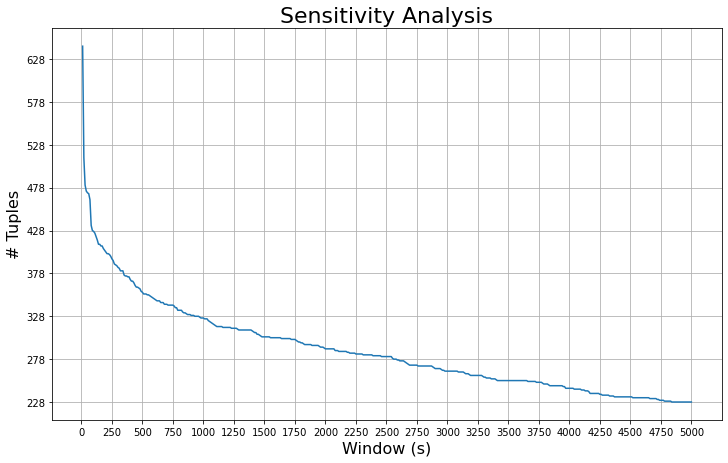

In [10]:
plt.figure(figsize = (12, 7.2))
plt.plot(sens_an_df.win_dim, sens_an_df.num_tuples)
plt.title('Sensitivity Analysis', size=22)
plt.xlabel('Window (s)', size=16)
plt.ylabel('# Tuples', size=16)
plt.xticks(np.arange(min(sens_an_df.win_dim-10), max(sens_an_df.win_dim+250), 250))
plt.yticks(np.arange(min(sens_an_df.num_tuples), max(sens_an_df.num_tuples), 50))
plt.grid()
plt.show()

## Creazione tuple

In [11]:
def create_tuples(dataframe, dim_win):
    tuples = []
    timestamp = dataframe.Timestamp
    tup=0
    prec=0
    for t in timestamp:
        if (t - prec)>dim_win:
            tup=tup+1
        tuples.append(tup)
        prec=t     
    dataframe['Tuple']=tuples
    return dataframe

### bluegene df con tupla di appartenenza

In [12]:
W=500
bluegene_df_tupled = create_tuples(bluegene_df,W)
bluegene_df_tupled

Timestamp       Node     Card                                            Message Rack          node_card  Tuple
0       1128621350  R00-M0-N0  J18-U01   Lustre mount FAILED : bglio2 : block_id : loc...  R00  R00-M0-N0/J18-U01      1
1       1128621350  R01-M1-N0  J18-U11   Lustre mount FAILED : bglio21 : block_id : lo...  R01  R01-M1-N0/J18-U11      1
2       1128621351  R07-M0-NC  J18-U01   Lustre mount FAILED : bglio124 : block_id : l...  R07  R07-M0-NC/J18-U01      1
3       1128621351  R00-M0-N4  J18-U01   Lustre mount FAILED : bglio4 : block_id : loc...  R00  R00-M0-N4/J18-U01      1
4       1128621351  R02-M0-N4  J18-U01   Lustre mount FAILED : bglio36 : block_id : lo...  R02  R02-M0-N4/J18-U01      1
...            ...        ...      ...                                                ...  ...                ...    ...
125619  1136390405  R00-M0-NC  J18-U11      idoproxy communication failure: socket closed  R00  R00-M0-NC/J18-U11    356
125620  1136390405  R36-M0-NC  J18-U11      idoproxy communication failure: socket closed  R36  R36-M0-NC/J18-U11    356
125621  1136390405  R30-M0-NC  J18-U11      idoproxy communication failure: socket closed  R30  R30-M0-NC/J18-U11    356
125622  1136390405  R31-M0-NC  J18-U11      idoproxy communication failure: socket closed  R31  R31-M0-NC/J18-U11    356
125623  1136390405  R34-M0-NC  J18-U11      idoproxy communication failure: socket closed  R34  R34-M0-NC/J18-U11    356

[125624 rows x 7 columns]

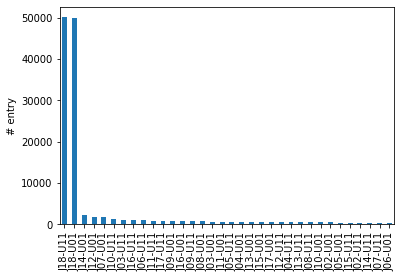

In [13]:
bluegene_df_tupled.Card.value_counts().plot(x="A", y="B",kind='bar', ylabel='# entry');

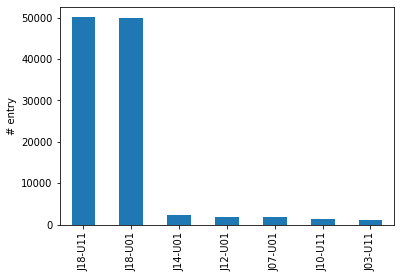

In [14]:
bluegene_df_tupled.Card.value_counts()[bluegene_df_tupled.Card.value_counts()>1000].plot(x="A", y="B",kind='bar', ylabel='# entry');

bluegene_df_tupled['card_mod'] = bluegene_df_tupled['Card'].replace(['J18-U11','J18-U01'],'IO')

### Finestra temporale scelta:  W=500 -> numero tuple

In [15]:
len(bluegene_df_tupled.Tuple.unique())

356

### df dei tempi di interarrivo: distanza tra ultimo timestamp della tupla i e il primo della i+1

In [16]:
bluegene_df_gr = bluegene_df_tupled.groupby('Tuple')

In [17]:
inter = []
t = []

for k,i in bluegene_df_gr: 
    if (k != len(bluegene_df_gr)):
        inter.append(bluegene_df_gr.get_group(k+1)['Timestamp'].min() - bluegene_df_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

tuples_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})
tuples_interarrivals_df

Tuples  Interarrivals
0        Tuple 1-2          19914
1        Tuple 2-3          61004
2        Tuple 3-4          16776
3        Tuple 4-5          28641
4        Tuple 5-6          46370
..             ...            ...
350  Tuple 351-352         175640
351  Tuple 352-353         154427
352  Tuple 353-354          30655
353  Tuple 354-355           4368
354  Tuple 355-356          67729

[355 rows x 2 columns]

In [18]:
dfi.export(tuples_interarrivals_df,"tuples_interarrivals.png", max_rows=10)

### statistiche tuple (starting, ending point, numero tuple ecc)

In [19]:
first = []
last = []
length= []
tupla = []
list_nodes = []
list_nodes_ext = []
n_nodes = []
n_entry = []
racks = []
num_racks = []
node_card = []
num_node_card = []



for k,i in bluegene_df_gr: 
    maxim=bluegene_df_gr.get_group(k)['Timestamp'].max()
    minim=bluegene_df_gr.get_group(k)['Timestamp'].min()    
    l=maxim - minim
    list_n_ext = bluegene_df_gr.get_group(k)['Node']
    list_n = set(list_n_ext)
    rac = bluegene_df_gr.get_group(k)['Rack']
    racks.append(set(rac))
    num_racks.append(len(set(rac))) 
    n_c = bluegene_df_gr.get_group(k)['card_mod']    
    
    node_card.append(set(n_c))
    num_node_card.append(len(set(n_c)))
    
    list_nodes_ext.append(tuple(list_n_ext))
    n_entry.append(len(i))
    n_nodes.append(len(list_n))
    list_nodes.append(tuple(list_n))
    first.append(minim)
    last.append(maxim)
    tupla.append(k)
    length.append(l)
    

tuples_points_df = pd.DataFrame({'Tuple' : tupla, 'Num_entries' : n_entry,'Starting_point' : first, 'Ending_point' : last, 'Length':length, 'Num_nodes':n_nodes, 'Nodes': list_nodes, 'Nodes_extended':list_nodes_ext, 'Racks':racks, 'Num_racks':num_racks, 'Card': node_card, 'Num_card': num_node_card})

tuples_points_df

Tuple  Num_entries  Starting_point  Ending_point  ...                                              Racks  Num_racks           Card Num_card
0        1          128      1128621350    1128621367  ...           {R05, R06, R00, R01, R04, R07, R02, R03}          8           {IO}        1
1        2         1024      1128641281    1128641411  ...  {R27, R52, R40, R63, R00, R64, R76, R34, R04, ...         64           {IO}        1
2        3           23      1128702415    1128702464  ...                                              {R61}          1      {J10-U11}        1
3        4            9      1128719240    1128719316  ...                                              {R06}          1      {J11-U11}        1
4        5           14      1128747957    1128748024  ...                                              {R23}          1      {J17-U11}        1
..     ...          ...             ...           ...  ...                                                ...        ...            ...      ...
351    352           32      1136133055    1136133059  ...                                         {R34, R35}          2           {IO}        1
352    353          264      1136287486    1136287526  ...           {R24, R20, R27, R23, R22, R26, R21, R25}          8  {IO, J11-U11}        2
353    354            2      1136318181    1136318198  ...                                         {R76, R52}          2           {IO}        1
354    355          333      1136322566    1136322676  ...  {R27, R52, R63, R40, R00, R64, R76, R34, R04, ...         64           {IO}        1
355    356            8      1136390405    1136390405  ...                {R50, R20, R30, R00, R31, R34, R36}          7           {IO}        1

[356 rows x 12 columns]

### Tupla più densa

In [20]:
max_perc=tuples_points_df.Num_entries.max()/tuples_points_df.Num_entries.values.sum()
print(max_perc)

tuples_points_df.iloc[tuples_points_df.Num_entries.idxmax()]

0.1017639941412469


Tuple                                                           300
Num_entries                                                   12784
Starting_point                                           1134158825
Ending_point                                             1134161719
Length                                                         2894
Num_nodes                                                       320
Nodes             (R26-M1-NC, R06-M1-N4, R25-M0-N4, R33-M0-N4, R...
Nodes_extended    (R63-M0-N0, R63-M1-NC, R63-M0-N0, R63-M0-NC, R...
Racks             {R27, R63, R00, R64, R34, R04, R26, R02, R13, ...
Num_racks                                                        40
Card                                                           {IO}
Num_card                                                          1
Name: 299, dtype: object

In [21]:
dfi.export(tuples_points_df[['Tuple', 'Num_entries', 'Starting_point', 'Ending_point', 'Length','Num_nodes','Nodes']], "tuples_stats.png", max_rows=10)

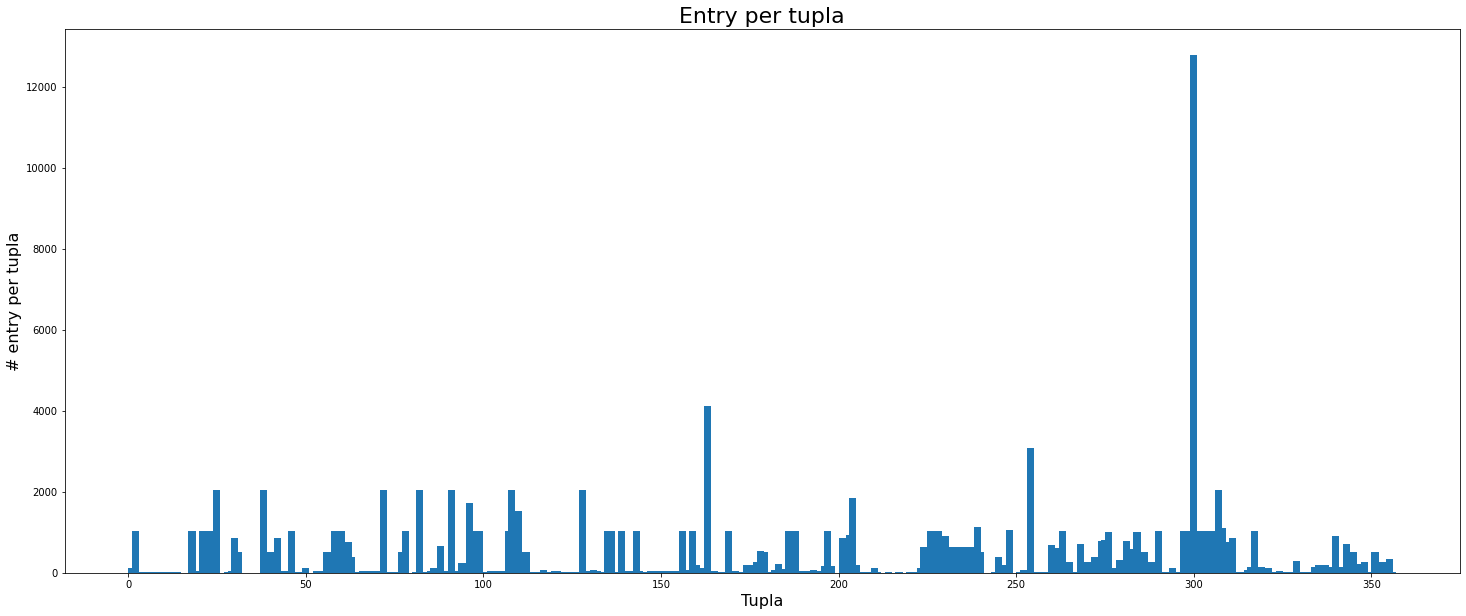

In [22]:
plt.figure(figsize = (25, 10))
plt.ylabel('# entry per tupla', size=16)
plt.xlabel('Tupla', size=16)
plt.title('Entry per tupla', size=22)
plt.bar(x=tuples_points_df.Tuple, width=2, height=tuples_points_df.Num_entries, align='center');

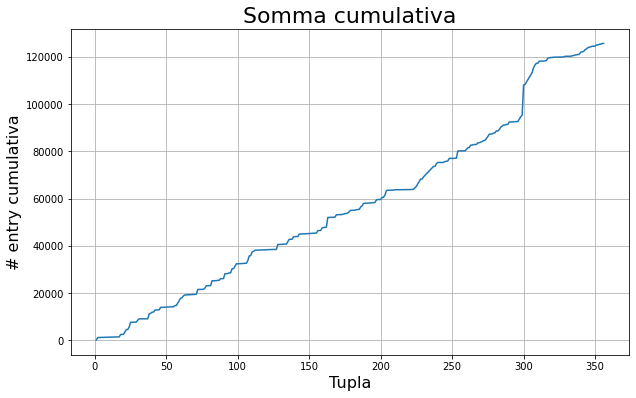

In [23]:
plt.figure(figsize = (10, 6))
plt.ylabel('# entry cumulativa', size=16)
plt.xlabel('Tupla', size=16)
plt.title('Somma cumulativa', size=22)
plt.grid()
plt.plot(tuples_points_df.Tuple, tuples_points_df.Num_entries.cumsum())
plt.show();

In [24]:
import plotly.express as px
fig = px.line(x=tuples_points_df.Tuple, y=tuples_points_df.Num_entries.cumsum())
fig.show()

In [25]:
start_tuple = 300
end_tuple = 300

tuples_bottleneck = tuples_points_df.iloc[range(start_tuple -1, end_tuple)]

print("Percentuale di entry contenute nel range: ", tuples_bottleneck.Num_entries.values.sum()/tuples_points_df.Num_entries.values.sum())

start_ts = tuples_bottleneck.iloc[0]['Starting_point']
end_ts = tuples_bottleneck.iloc[-1]['Ending_point']

start_date = dt.fromtimestamp(start_ts)
end_date = dt.fromtimestamp(end_ts)

start_log = tuples_points_df.iloc[0]['Starting_point']
end_log = tuples_points_df.iloc[-1]['Ending_point']

start_log = dt.fromtimestamp(start_log)
end_log = dt.fromtimestamp(end_log)

print("Inizio: ", start_date, "   Fine: ", end_date, "   Durata: ", end_date - start_date)

print("Inizio: ", start_log, "   Fine: ", end_log, "   Durata: ", end_log - start_log)

Percentuale di entry contenute nel range:  0.1017639941412469
Inizio:  2005-12-09 21:07:05    Fine:  2005-12-09 21:55:19    Durata:  0:48:14
Inizio:  2005-10-06 19:55:50    Fine:  2006-01-04 17:00:05    Durata:  89 days, 21:04:15


#### L'analisi sui nodi viene male, troppi nodi a pari merito, meglio sulle Card

In [26]:
entry_bottleneck = bluegene_df[(bluegene_df["Timestamp"]>= start_ts) & (bluegene_df["Timestamp"]<=end_ts)]

entry_bottleneck.Node.value_counts()#[entry_bottleneck.Node.value_counts() > 40].plot(kind="bar");
# entry_bottleneck.Card.value_counts().plot(kind="bar");


R33-M1-N4    42
R34-M1-N4    42
R15-M0-N0    42
R31-M0-N8    42
R25-M1-NC    42
             ..
R63-M0-NC    18
R62-M0-N8     2
R62-M0-NC     2
R62-M0-N0     2
R62-M0-N4     2
Name: Node, Length: 320, dtype: int64

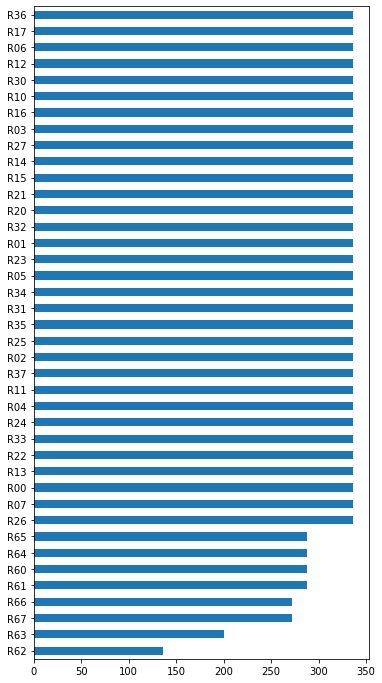

In [27]:
entry_bottleneck.Rack.value_counts(ascending=True).plot(kind="barh", figsize=(6,12));

In [28]:
pd.options.display.max_colwidth = 150

temp = entry_bottleneck.Message.value_counts().rename_axis('Message').reset_index(name='Counts')

dfi.export(temp,"messages_bottleneck.png", max_rows=30)

### Calcolo Bottleneck tupla 300

In [29]:
chained = list(itertools.chain(*tuples_bottleneck.Nodes_extended))

count = Counter(elem for elem in chained)
count = dict(count)

# print(count)

## Analisi di Truncation
### Nodi comuni a tuple consecutive con 15° percentile, con rispettivi sottosistemi in errore

In [30]:
import time 

time.strftime("%H:%M:%S", time.gmtime(tuples_interarrivals_df.Interarrivals.max()))

np.percentile(tuples_interarrivals_df['Interarrivals'], 20)

2236.3999999999996

In [31]:
t = []
commons_node = []
com_n_first = []
com_n_last = []
percentile = 20

n_trunc = 0

for k,i in bluegene_df_gr: 
    if (k != len(bluegene_df_gr)):
        common=list(set( bluegene_df_gr.get_group(k+1)['Node']) & set(bluegene_df_gr.get_group(k)['Node']))
        if (common and ((bluegene_df_gr.get_group(k+1)['Timestamp'].min() - bluegene_df_gr.get_group(k)['Timestamp'].max()) < np.percentile(tuples_interarrivals_df['Interarrivals'], percentile))):
            n_trunc = n_trunc + 1
        df_common = pd.DataFrame({"Node":common})
        merged_1 = pd.merge(bluegene_df_gr.get_group(k+1), df_common, how="inner", left_on="Node", right_on="Node")
        merged_2 = pd.merge(bluegene_df_gr.get_group(k), df_common, how="inner", left_on="Node", right_on="Node")
        
        col_1 = merged_1['Node'] +"/"+ merged_1['Card']
        col_1 = list(col_1)
        col_1 = list(dict.fromkeys(col_1))
        
        col_2 = merged_2['Node'] +"/"+ merged_2['Card']
        col_2 = list(col_2)
        col_2 = list(dict.fromkeys(col_2))       
        
        t.append('Tuple '+str(k)+'-'+str(k+1))
        commons_node.append(tuple(common))
        com_n_first.append(tuple(col_1))
        com_n_last.append(tuple(col_2))
         
tuples_common_df = pd.DataFrame({'Tuple' : t, 'Common_nodes' : commons_node, 'Common_nodes_with_subsys_first_tuple': com_n_first, 'Common_nodes_with_subsys_last_tuple': com_n_last})

In [74]:
tuples_common_df[tuples_common_df.Common_nodes != ()]

Tuple                                                                                                                                           Common_nodes  \
0        Tuple 1-2  (R01-M1-NC, R06-M0-N0, R00-M0-N0, R06-M1-N4, R04-M0-N0, R03-M0-NC, R06-M1-NC, R05-M1-N8, R04-M1-N4, R02-M1-N8, R03-M0-N4, R07-M1-N8, R07-M1-N4, R0...   
15     Tuple 16-17                                                                                                                                           (R44-M1-N1,)   
17     Tuple 18-19                                                                                                                                           (R27-M1-N8,)   
20     Tuple 21-22  (R26-M1-NC, R06-M1-N4, R40-M1-NC, R57-M1-N8, R72-M0-N8, R25-M0-N4, R33-M0-N4, R74-M1-N8, R26-M0-NC, R67-M1-N8, R12-M0-N8, R32-M1-NC, R46-M0-N8, R0...   
23     Tuple 24-25  (R26-M1-NC, R06-M1-N4, R40-M1-NC, R57-M1-N8, R72-M0-N8, R25-M0-N4, R33-M0-N4, R74-M1-N8, R26-M0-NC, R67-M1-N8, R12-M0-N8, R32-M1-NC, R46-M0-N8, R0...   
24     Tuple 25-26                                                                                                                                           (R00-M0-NC,)   
25     Tuple 26-27                                                                                                                                           (R00-M0-NC,)   
27     Tuple 28-29                                                                                                                                           (R51-M0-N8,)   
28     Tuple 29-30                                                                                                                                           (R51-M0-N8,)   
29     Tuple 30-31  (R51-M1-NC, R42-M0-N4, R40-M1-NC, R41-M1-N4, R44-M0-N4, R75-M1-N4, R64-M0-N0, R57-M1-N8, R74-M1-N8, R66-M1-NC, R40-M1-N8, R52-M0-N0, R75-M0-N0, R7...   
31     Tuple 32-33                                                                                                                                           (R36-M1-N5,)   
32     Tuple 33-34                                                                                                                                           (R36-M1-N5,)   
33     Tuple 34-35                                                                                                                                           (R36-M1-N5,)   
34     Tuple 35-36                                                                                                                                           (R36-M1-N5,)   
35     Tuple 36-37                                                                                                                                           (R36-M1-N5,)   
37     Tuple 38-39  (R51-M1-NC, R42-M0-N4, R40-M1-NC, R41-M1-N4, R44-M0-N4, R57-M1-N8, R40-M1-N8, R52-M0-N0, R41-M0-N0, R43-M1-N0, R46-M0-N8, R50-M1-N8, R47-M1-NC, R4...   
39     Tuple 40-41                                                                                                                                           (R02-M0-N4,)   
40     Tuple 41-42                                                                                                                                           (R02-M0-N4,)   
41     Tuple 42-43                                                                                                                                           (R02-M0-N4,)   
42     Tuple 43-44                                                                                                                                           (R02-M0-N4,)   
44     Tuple 45-46  (R00-M0-N0, R40-M0-NC, R70-M0-N4, R60-M1-N8, R30-M0-N0, R40-M0-N8, R00-M0-N8, R30-M0-NC, R60-M1-NC, R60-M1-N0, R40-M0-N4, R60-M1-N4, R00-M0-NC, R5...   
48     Tuple 49-50                                                                                                                                           (R53-M1-NC,)   
57     Tuple 58-59  (R26-M1-NC, R0

### Calcolo percentuale di truncation

In [33]:
# tuples_common_df.Common_nodes.value_counts()

In [34]:
num_nan = tuples_common_df.Common_nodes.value_counts()[()]

truncation_perc_raw = (len(bluegene_df_gr)-num_nan)/len(bluegene_df_gr)

print("Truncation iniziale: ", truncation_perc_raw)

truncation_perc = n_trunc / len(bluegene_df_gr)
print("La percentuale di truncation è pari a: ", truncation_perc, "\nTotale è: ", n_trunc)

Truncation iniziale:  0.40168539325842695
La percentuale di truncation è pari a:  0.1151685393258427 
Totale è:  41


### Calcolo percentuale di collision

In [35]:
one_nodes=tuples_points_df.Num_nodes.value_counts()[1]

collision_perc = (len(bluegene_df_gr) - one_nodes) / len(bluegene_df_gr)


print("La percentuale di collassi è pari a: ",collision_perc)
print("Il numero di collassi è pari a: ", len(bluegene_df_gr) - one_nodes)

La percentuale di collassi è pari a:  0.6685393258426966
Il numero di collassi è pari a:  238


In [36]:
one_racks=tuples_points_df.Num_racks.value_counts()[1]

collision_perc = (len(bluegene_df_gr) - one_racks) / len(bluegene_df_gr)


print("La percentuale di collassi è pari a: ",collision_perc)
print("Il numero di collassi è pari a: ", len(bluegene_df_gr) - one_racks)

La percentuale di collassi è pari a:  0.49719101123595505
Il numero di collassi è pari a:  177


In [37]:
one_card=tuples_points_df.Num_card.value_counts()[1]

collision_perc = (len(bluegene_df_gr) - one_card) / len(bluegene_df_gr)


print("La percentuale di collassi è pari a: ",collision_perc)
print("Il numero di collassi è pari a: ", len(bluegene_df_gr) - one_card)

La percentuale di collassi è pari a:  0.15730337078651685
Il numero di collassi è pari a:  56


In [38]:
tuples_points_df[tuples_points_df.Num_card > 2]

Tuple  Num_entries  Starting_point  Ending_point  ...            Racks  Num_racks  \
72      73           12      1130088160    1130088175  ...  {R30, R31, R10}          3   
75      76           12      1130136967    1130136979  ...  {R30, R31, R10}          3   
90      91         2048      1130529570    1130529627  ...       {R62, R63}          2   
134    135         1024      1131483538    1131483566  ...            {R63}          1   
135    136         1024      1131486120    1131486155  ...            {R63}          1   
138    139         1024      1131499502    1131499531  ...            {R62}          1   
142    143         1024      1131680318    1131680354  ...            {R63}          1   
153    154           45      1132018679    1132018711  ...       {R41, R57}          2   
155    156         1024      1132021522    1132021550  ...            {R46}          1   
156    157           75      1132035291    1132035294  ...       {R55, R51}          2   
162    163         4128      1132110660    1132111278  ...       {R56, R57}          2   
168    169         1024      1132173418    1132173448  ...            {R46}          1   
238    239         1128      1133200780    1133200923  ...            {R63}          1   
295    296           12      1134093484    1134093488  ...            {R63}          1   

                                                                                                                                                      Card Num_card  
72                                                                                                  {J17-U11, J13-U01, J16-U11, J15-U01, J05-U01, J17-U01}        6  
75                                                                                                           {J17-U11, J13-U01, J16-U11, J15-U01, J05-U01}        5  
90   {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
134  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
135  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
138  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
142  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
153                                                                                                                            {J14-U01, J03-U11, J11-U11}        3  
155  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, J06-U01, J03-U11, J...       32  
156                                                                                                                   {J07-U11, J08-U01, J14-U11, J03-U11}        4  
162  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J15-U01, J17-U01, J04-U01, IO, J06-U01, J03-U1...       33  
168  {J14-U01, J07-U11, J08-U11, J06-U11, J10-U11, J11-U01, J14-U11, J11-U11, J09-U01, J10-U01, J05-U11, J07-U01, J15-U01, J04-U01, J06-U01, J03-U11, J...       32  
238                                                                                    {J09-U11, J08-U11, J10-U11, J11-U01, J11-U11, J08-U01, IO, J09-U01}        8  
295                                                                                                                                 {IO, J10-U01, J12-U01}        3  

[14 rows x 12 columns]

In [39]:
ciod_and_u = bluegene_df_tupled[(bluegene_df_tupled.Message.str.contains("ciod:")) & ((bluegene_df_tupled.Card.str.contains("U01")) | (bluegene_df_tupled.Card.str.contains("U11")))]

only_ciod = bluegene_df_tupled[(bluegene_df_tupled.Message.str.contains("ciod:"))]

print(len(ciod_and_u), len(only_ciod))

95678 95678


Quindi le card che finiscono con u01, u11 sono di IO? Pare di sì. Quindi j18-u01 e u11 sono legati allo stesso fallimento. li accorpo.

In [40]:
# bluegene_df_tupled['card_mod'] = bluegene_df_tupled['Card'].replace(['J18-U11','J18-U01'],'IO')

## Goodness of Fitting

Results from Fit_Everything:
Analysis method: LS
Failures / Right censored: 355/0 (0% right censored) 

   Distribution   Alpha     Beta        Gamma      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD
     Weibull_3P 16307.9 0.646798      502.999                                    -3837.63 7681.33 7692.88 0.418728
       Gamma_3P 38070.6 0.530609      502.999                                    -3839.59 7685.25  7696.8 0.987955
   Lognormal_2P                               9.09143 1.44732                     -3863.3 7730.64 7738.35  1.95284
   Lognormal_3P                       197.093 9.08318  1.6768                    -3862.49 7731.06 7742.61  1.39633
 Loglogistic_2P 8878.85  1.20484                                                 -3876.22 7756.48 7764.19  3.24941
     Weibull_2P 17606.9 0.838365                                                 -3877.81 7759.65 7767.36  4.26885
 Loglogistic_3P 8988.19  1.00532      109.932                                    -3876.29 7

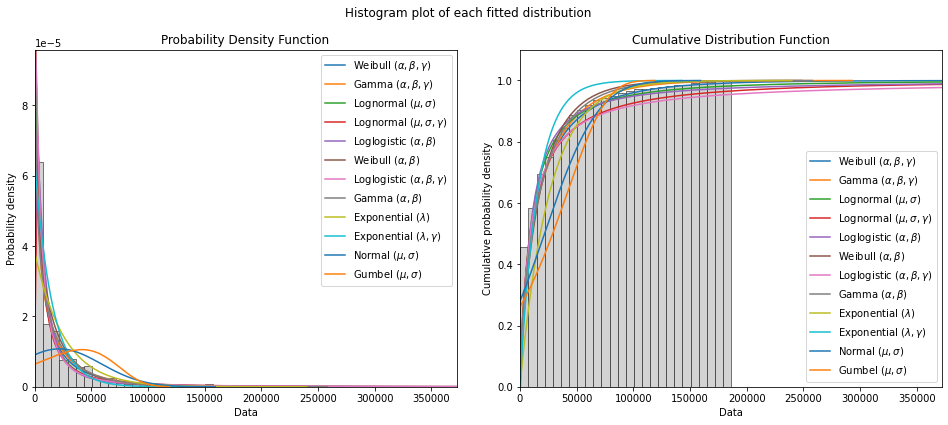

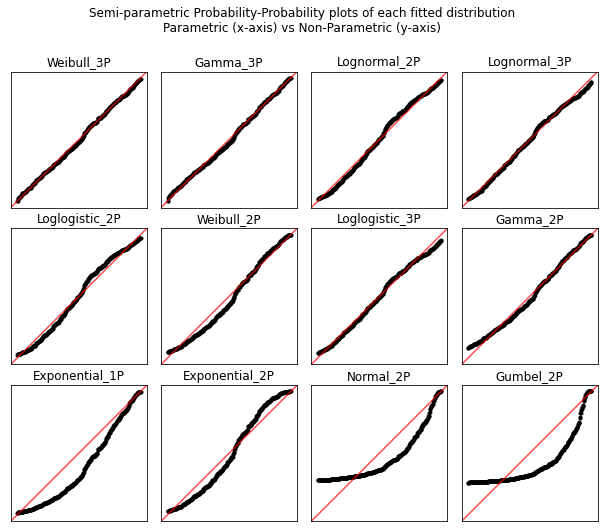

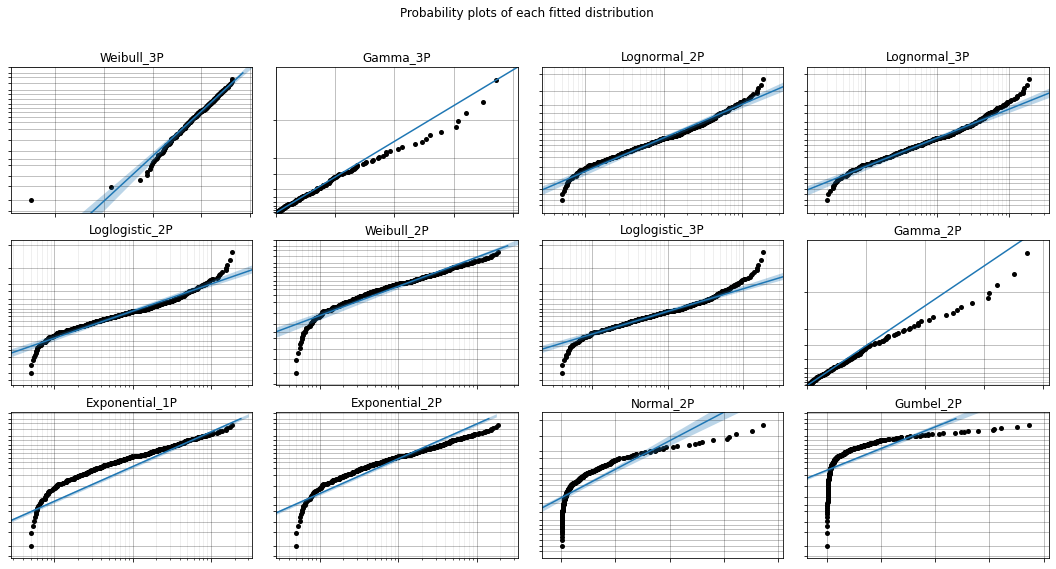

The best fitting distribution was Weibull_3P which had parameters [1.63078720e+04 6.46798247e-01 5.02999000e+02]


In [41]:
from reliability.Fitters import Fit_Everything
from reliability.Distributions import Weibull_Distribution
from reliability.Reliability_testing import KStest

results = Fit_Everything(failures=list(tuples_interarrivals_df.Interarrivals), method="LS")  # fit all the models
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

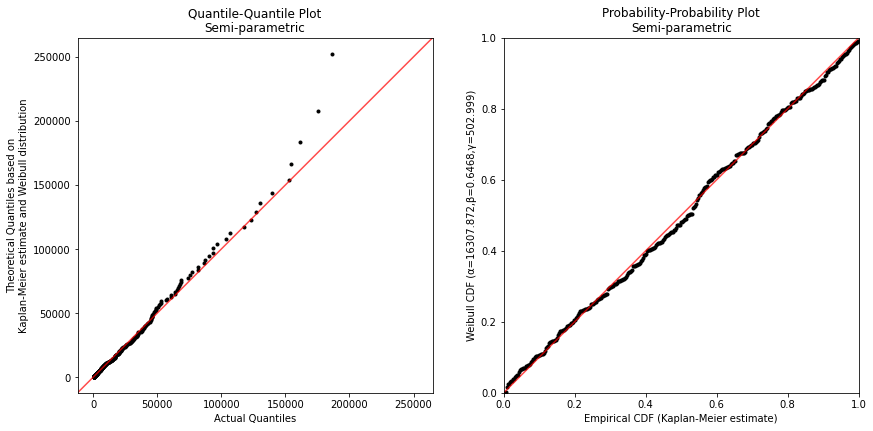

In [42]:
from reliability.Probability_plotting import PP_plot_semiparametric, QQ_plot_semiparametric
from reliability.Fitters import Fit_Normal_2P
from reliability.Distributions import Weibull_Distribution
import matplotlib.pyplot as plt


data=list(tuples_interarrivals_df.Interarrivals)
plt.figure(figsize=(14,8))
plt.subplot(121)
QQ_plot_semiparametric(X_data_failures=data,Y_dist=results.best_distribution, show_fitted_lines=False,show_diagonal_line=True)
plt.subplot(122)
PP_plot_semiparametric(X_data_failures=data,Y_dist=results.best_distribution)
plt.show()

Results from Kolmogorov-Smirnov test:
Kolmogorov-Smirnov statistic: 0.02623979005454169
Kolmogorov-Smirnov critical value: 0.0715935680326272
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=16307.872,β=0.6468,γ=502.999)


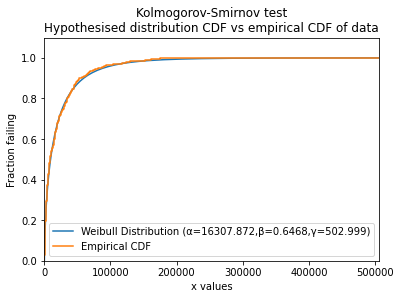

In [43]:
KStest(distribution=results.best_distribution, data=list(tuples_interarrivals_df.Interarrivals));

### Calcolo R squared

In [44]:
wb_data = Weibull_Distribution(alpha=1.63078720e+04,beta=6.46798247e-01,gamma=5.02999000e+02).random_samples(355, seed=42)

x_wb = np.sort(wb_data)
y_wb = np.arange(len(x_wb))/float(len(x_wb))

In [45]:
from sklearn.metrics import r2_score

x = np.sort(tuples_interarrivals_df.Interarrivals)
y = np.arange(len(x))/float(len(x))

# r2 = r2_score(x_wb, x)
# r2

In [46]:
def ssd(A,B):
    dif = A.ravel() - B.ravel()
    return np.dot( dif, dif )

def r2_sse_sst(Y, Y_HAT):
    ssr, sse, r_sqr = [0]*3
    y_ = np.mean(Y)
    ssr = sum([(y_hat - y_)**2 for y_hat in Y_HAT])
    sse = sum([(y - y_hat)**2 for y,y_hat in zip(Y, Y_HAT)])
    sst = sum([(y - y_)**2 for y in Y])
    r_sqr = 1 - (sse / sst)
    return r_sqr, sse, sst

In [47]:
r2, sse, sst=r2_sse_sst(x_wb, x)
print("R-squared: {} \nSSE:       {} \nSST:       {}".format(r2, sse, sst))

R-squared: 0.9837567491816327 
SSE:       4688444917.676893 
SST:       288639569141.87195


### Reliability empirica

In [48]:
tuples_interarrivals_df.to_csv("bluegene.csv", header=True)

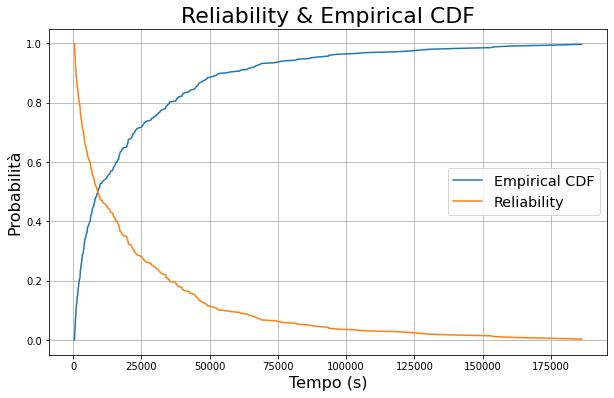

In [49]:
x = np.sort(tuples_interarrivals_df.Interarrivals)
y = np.arange(len(x))/float(len(x))

plt.figure(figsize = (10, 6))
plt.plot(x,y, label="Empirical CDF")
plt.plot(x,1-y, label="Reliability")
plt.title('Reliability & Empirical CDF', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='center right',fontsize = 'x-large')
plt.grid()
plt.show()

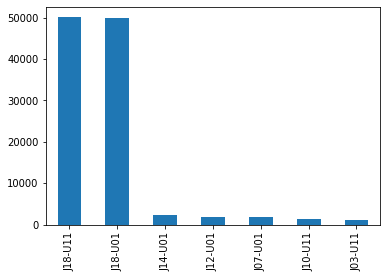

In [50]:
bluegene_df.Card.value_counts()[bluegene_df.Card.value_counts() > 1000].plot(kind="bar");

## Sensitivity Analysis per Card

J18-U01
File già esistente! Caricamento file...


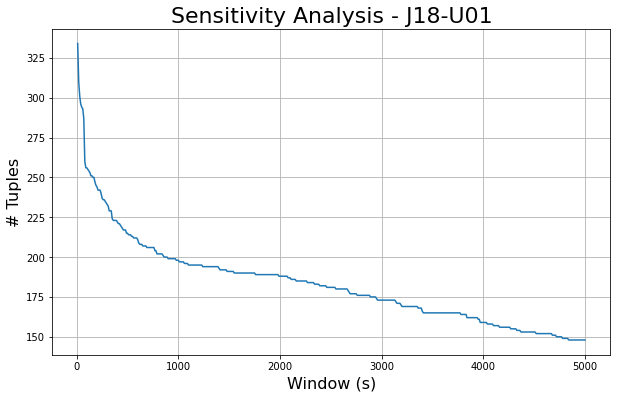

J18-U11
File già esistente! Caricamento file...


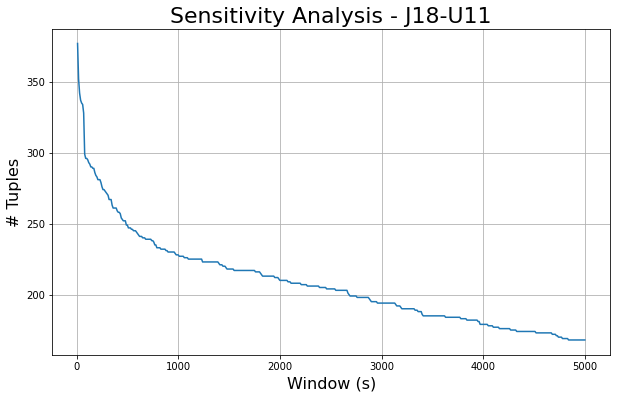

In [51]:
win_range = range(10, 5010, 10)

groups = bluegene_df.groupby('Card')

cards = ["J18-U11", "J18-U01"]
# pd.set_option('display.max_rows', None)


for k, i in groups:
    if k in cards:
        print(k)
        sens_an_df_err = tupling(groups.get_group(k), path+'/sensitivity_analysis_{}.csv'.format(k), win_range)
#         print(sens_an_df_err)
        plt.figure(figsize = (10, 6))
        plt.plot(sens_an_df_err.win_dim, sens_an_df_err.num_tuples)
        plt.title('Sensitivity Analysis - {}'.format(k), size=22)
        plt.xlabel('Window (s)', size=16)
        plt.ylabel('# Tuples', size=16)
        plt.grid()
        plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


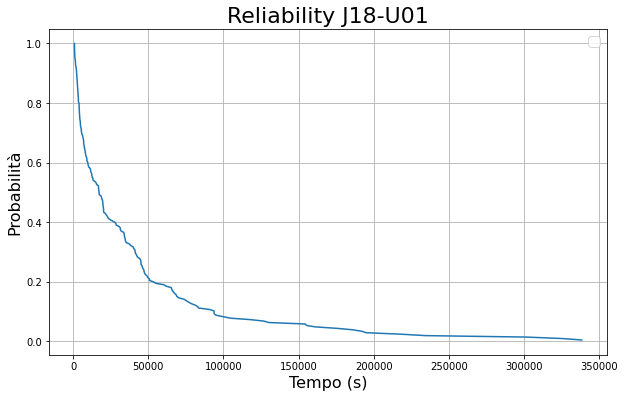

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


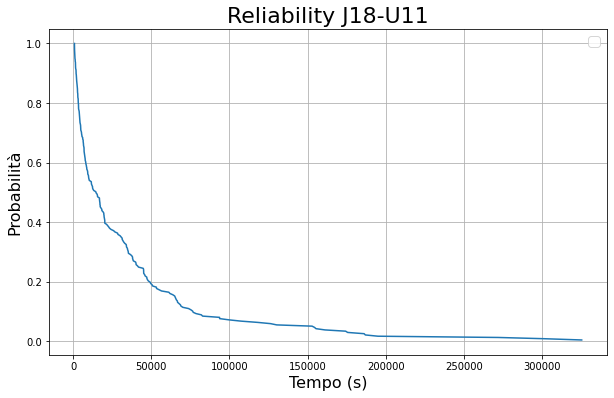

In [52]:
W=750

groups = bluegene_df.groupby('Card')
u01_tupled = create_tuples(groups.get_group("J18-U01"), W)


u01_gr = u01_tupled.groupby('Tuple')

inter = []
t = []

for k,i in u01_gr: 
    if (k != len(u01_gr)):
        inter.append(u01_gr.get_group(k+1)['Timestamp'].min() - u01_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

u01_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


u01_x_rid = np.sort(u01_interarrivals_df.Interarrivals)
# u01_x_rid = [i for i in  u01_x_rid if i <= 1000000]
u01_y = np.arange(len(u01_x_rid))/float(len(u01_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(u01_x_rid,1-u01_y)
plt.title('Reliability J18-U01', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()


groups = bluegene_df.groupby('Card')
u11_tupled = create_tuples(groups.get_group("J18-U11"), W)


u11_gr = u11_tupled.groupby('Tuple')

inter = []
t = []

for k,i in u11_gr: 
    if (k != len(u11_gr)):
        inter.append(u11_gr.get_group(k+1)['Timestamp'].min() - u11_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

u11_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


u11_x_rid = np.sort(u11_interarrivals_df.Interarrivals)
# u11_x_rid = [i for i in  u11_x_rid if i <= 1000000]
u11_y = np.arange(len(u11_x_rid))/float(len(u11_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(u11_x_rid,1-u11_y)
plt.title('Reliability J18-U11', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

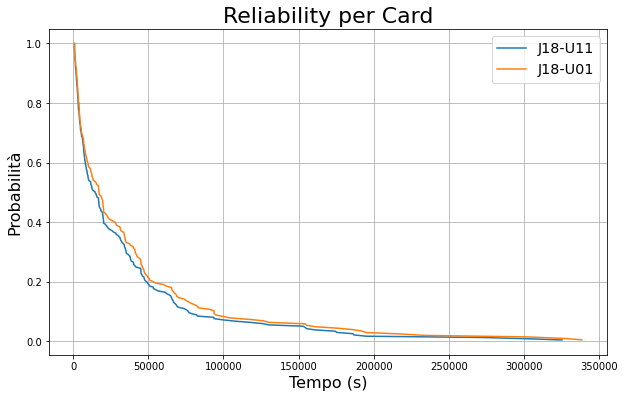

In [53]:
plt.figure(figsize = (10, 6))
plt.plot(u11_x_rid,1-u11_y, label="J18-U11")
plt.plot(u01_x_rid,1-u01_y, label="J18-U01")
plt.title('Reliability per Card', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

# Sensitivity Analysis per Rack

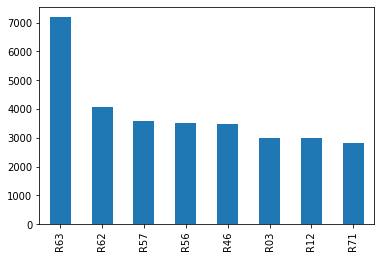

In [54]:
bluegene_df.Rack.value_counts()[bluegene_df.Rack.value_counts()>2500].plot(kind="bar");

R46
File già esistente! Caricamento file...


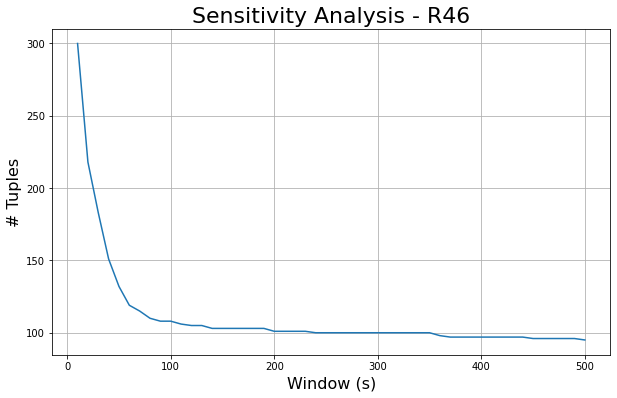

R56
File già esistente! Caricamento file...


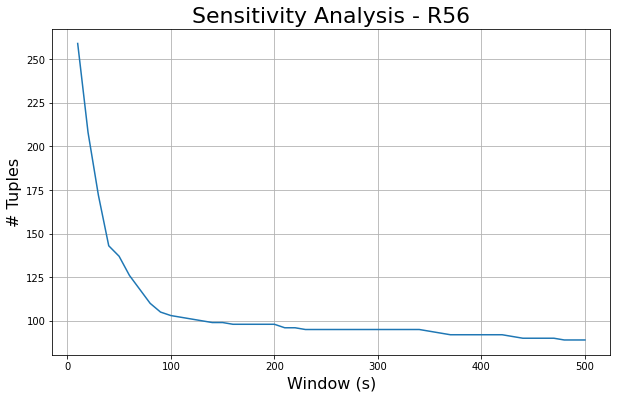

R57
File già esistente! Caricamento file...


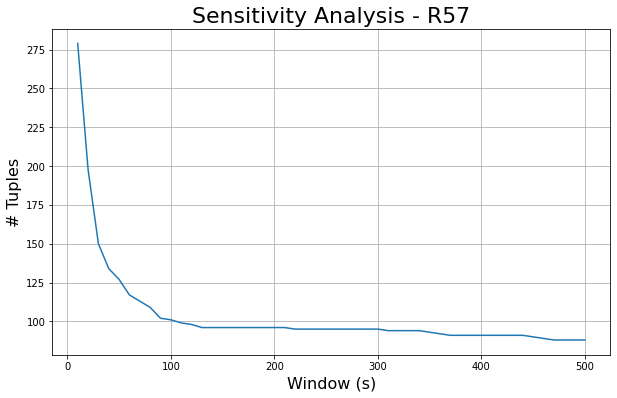

R62
File già esistente! Caricamento file...


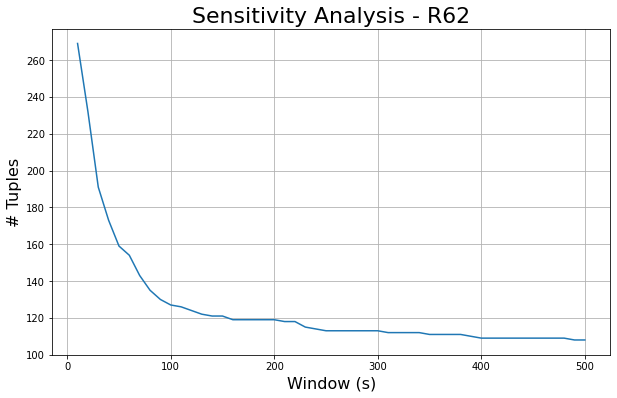

R63
File già esistente! Caricamento file...


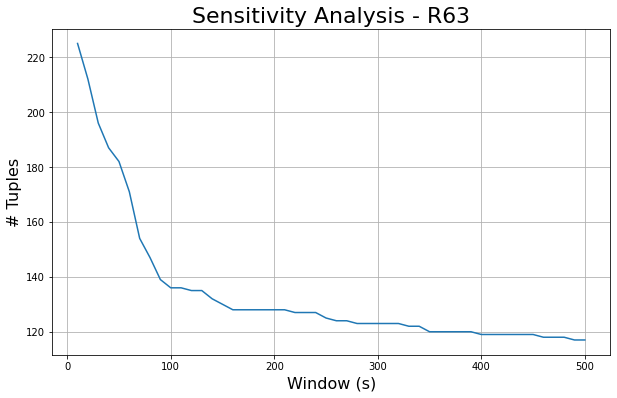

In [55]:
win_range = range(10, 510, 10)

groups = bluegene_df.groupby('Rack')
racks = ["R63", "R62", "R57", "R56", "R46"]

for k, i in groups:
    if k in racks:
        print(k)
        sens_an_df_err = tupling(groups.get_group(k), path+'/sensitivity_analysis_500_{}.csv'.format(k), win_range)
#         print(sens_an_df_err)
        plt.figure(figsize = (10, 6))
        plt.plot(sens_an_df_err.win_dim, sens_an_df_err.num_tuples)
        plt.title('Sensitivity Analysis - {}'.format(k), size=22)
        plt.xlabel('Window (s)', size=16)
        plt.ylabel('# Tuples', size=16)
        plt.grid()
        plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


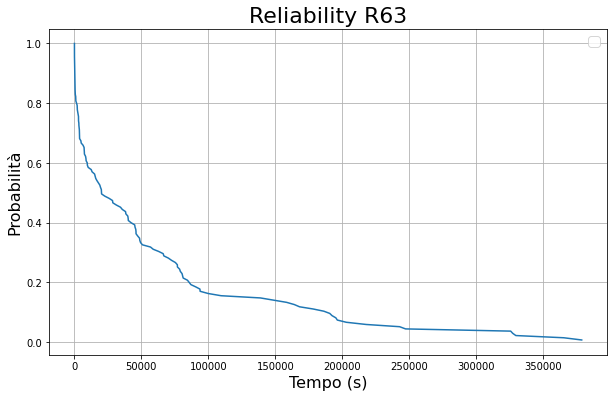

In [56]:
W=100

groups = bluegene_df.groupby('Rack')
r63_tupled = create_tuples(groups.get_group("R63"), W)


r63_gr = r63_tupled.groupby('Tuple')

inter = []
t = []

for k,i in r63_gr: 
    if (k != len(r63_gr)):
        inter.append(r63_gr.get_group(k+1)['Timestamp'].min() - r63_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

r63_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


r63_x_rid = np.sort(r63_interarrivals_df.Interarrivals)
# r63_x_rid = [i for i in  r63_x_rid if i <= 1000000]
r63_y = np.arange(len(r63_x_rid))/float(len(r63_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(r63_x_rid,1-r63_y)
plt.title('Reliability R63', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


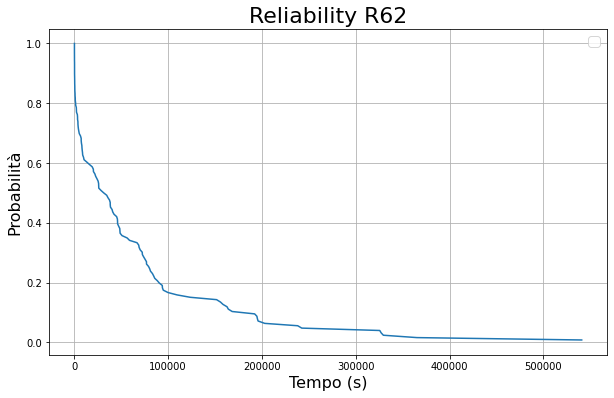

In [57]:
W=100

groups = bluegene_df.groupby('Rack')
r62_tupled = create_tuples(groups.get_group("R62"), W)


r62_gr = r62_tupled.groupby('Tuple')

inter = []
t = []

for k,i in r62_gr: 
    if (k != len(r62_gr)):
        inter.append(r62_gr.get_group(k+1)['Timestamp'].min() - r62_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

r62_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


r62_x_rid = np.sort(r62_interarrivals_df.Interarrivals)
# r62_x_rid = [i for i in  r62_x_rid if i <= 1000000]
r62_y = np.arange(len(r62_x_rid))/float(len(r62_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(r62_x_rid,1-r62_y)
plt.title('Reliability R62', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


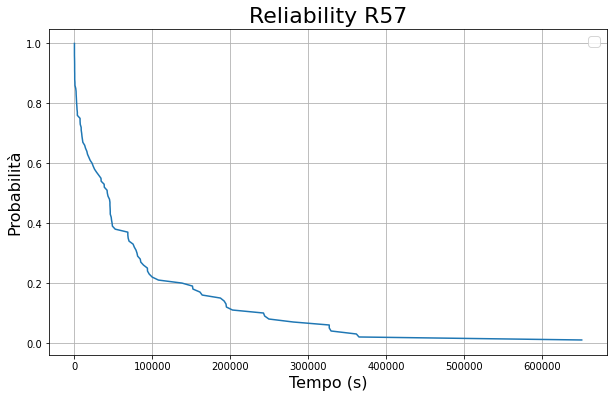

In [58]:
W=100

groups = bluegene_df.groupby('Rack')
r57_tupled = create_tuples(groups.get_group("R57"), W)


r57_gr = r57_tupled.groupby('Tuple')

inter = []
t = []

for k,i in r57_gr: 
    if (k != len(r57_gr)):
        inter.append(r57_gr.get_group(k+1)['Timestamp'].min() - r57_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

r57_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


r57_x_rid = np.sort(r57_interarrivals_df.Interarrivals)
# r57_x_rid = [i for i in  r57_x_rid if i <= 1000000]
r57_y = np.arange(len(r57_x_rid))/float(len(r57_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(r57_x_rid,1-r57_y)
plt.title('Reliability R57', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


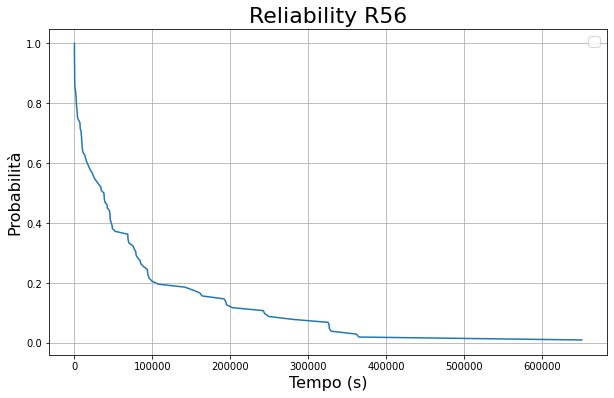

In [59]:
W=100

groups = bluegene_df.groupby('Rack')
r56_tupled = create_tuples(groups.get_group("R56"), W)


r56_gr = r56_tupled.groupby('Tuple')

inter = []
t = []

for k,i in r56_gr: 
    if (k != len(r56_gr)):
        inter.append(r56_gr.get_group(k+1)['Timestamp'].min() - r56_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

r56_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


r56_x_rid = np.sort(r56_interarrivals_df.Interarrivals)
# r56_x_rid = [i for i in  r56_x_rid if i <= 1000000]
r56_y = np.arange(len(r56_x_rid))/float(len(r56_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(r56_x_rid,1-r56_y)
plt.title('Reliability R56', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


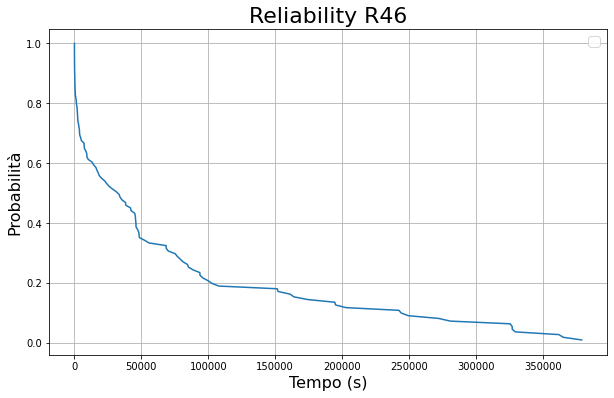

In [60]:
W=75

groups = bluegene_df.groupby('Rack')
r46_tupled = create_tuples(groups.get_group("R46"), W)


r46_gr = r46_tupled.groupby('Tuple')

inter = []
t = []

for k,i in r46_gr: 
    if (k != len(r46_gr)):
        inter.append(r46_gr.get_group(k+1)['Timestamp'].min() - r46_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

r46_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


r46_x_rid = np.sort(r46_interarrivals_df.Interarrivals)
# r46_x_rid = [i for i in  r46_x_rid if i <= 1000000]
r46_y = np.arange(len(r46_x_rid))/float(len(r46_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(r46_x_rid,1-r46_y)
plt.title('Reliability R46', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

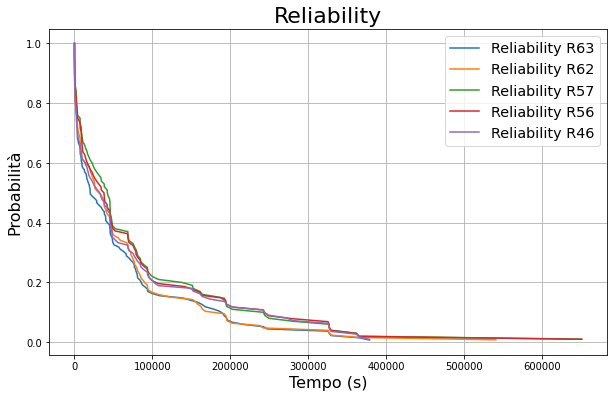

In [61]:
plt.figure(figsize = (10, 6))
plt.plot(r63_x_rid,1-r63_y, label="Reliability R63")
plt.plot(r62_x_rid,1-r62_y, label="Reliability R62")
plt.plot(r57_x_rid,1-r57_y, label="Reliability R57")
plt.plot(r56_x_rid,1-r56_y, label="Reliability R56")
plt.plot(r46_x_rid,1-r46_y, label="Reliability R46")

plt.title('Reliability', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

# Sensitivity analysis per nodi

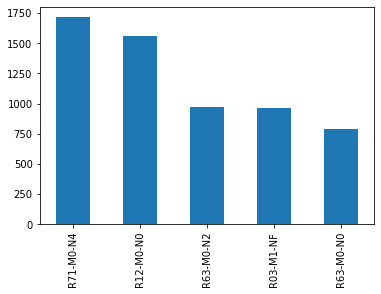

In [62]:
bluegene_df.Node.value_counts()[bluegene_df.Node.value_counts()>790].plot(kind="bar");

R03-M1-NF
File già esistente! Caricamento file...
    win_dim  num_tuples
0         0         145
1        50           8
2       100           8
3       150           8
4       200           8
5       250           8
6       300           8
7       350           8
8       400           8
9       450           8
10      500           8


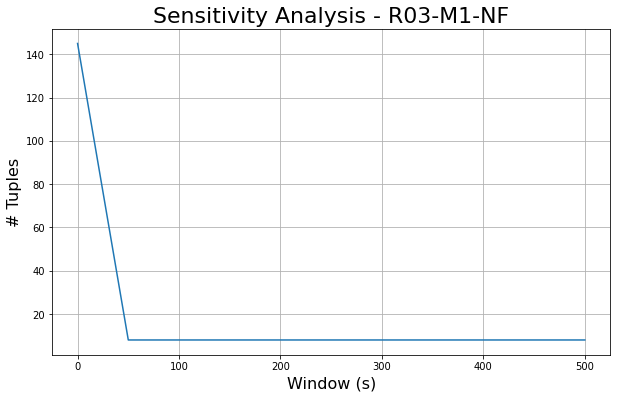

R12-M0-N0
File già esistente! Caricamento file...
    win_dim  num_tuples
0         0         322
1        50         109
2       100         103
3       150          82
4       200          78
5       250          76
6       300          73
7       350          73
8       400          73
9       450          73
10      500          73


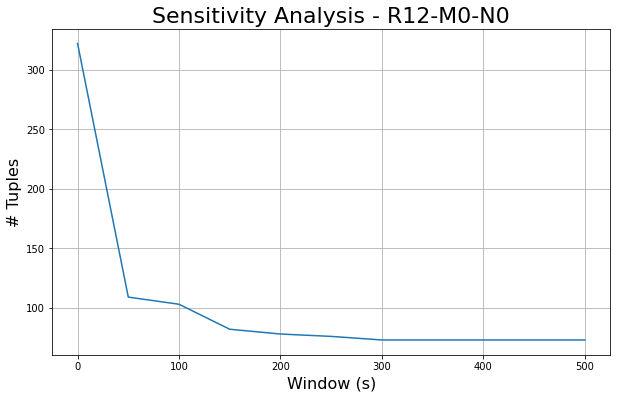

R63-M0-N0
File già esistente! Caricamento file...
    win_dim  num_tuples
0         0         210
1        50         138
2       100         119
3       150         113
4       200         109
5       250         108
6       300         106
7       350         103
8       400         102
9       450         102
10      500         101


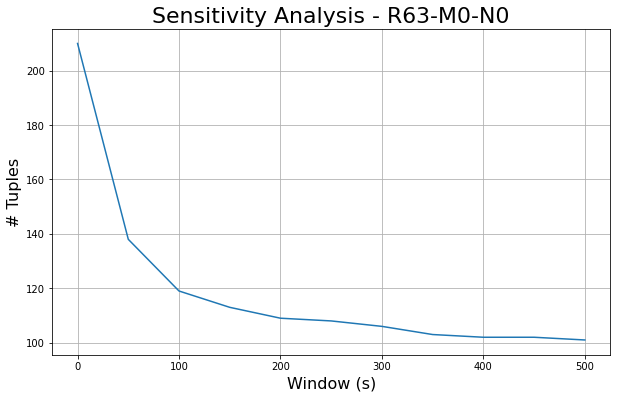

R63-M0-N2
File già esistente! Caricamento file...
    win_dim  num_tuples
0         0         109
1        50           4
2       100           4
3       150           4
4       200           4
5       250           4
6       300           4
7       350           4
8       400           4
9       450           4
10      500           4


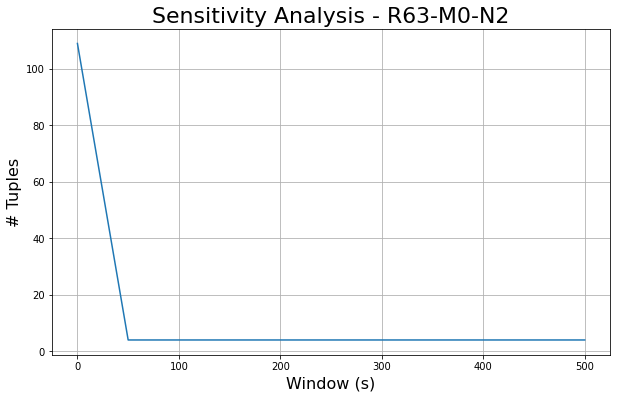

R71-M0-N4
File già esistente! Caricamento file...
    win_dim  num_tuples
0         0         330
1        50          97
2       100          94
3       150          81
4       200          75
5       250          74
6       300          72
7       350          72
8       400          72
9       450          72
10      500          72


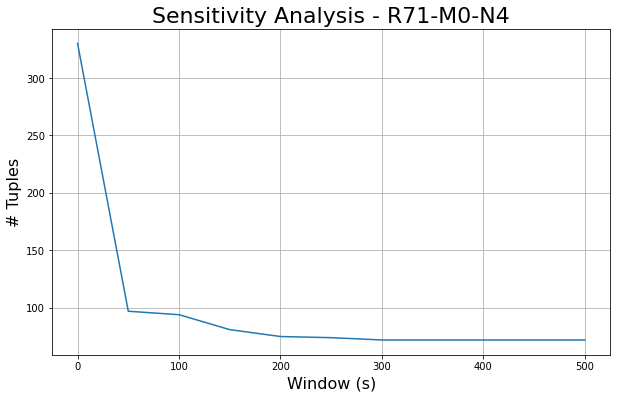

In [63]:
win_range = range(0, 550, 50)

groups = bluegene_df.groupby('Node')
cr_nodes = ['R71-M0-N4', 'R12-M0-N0', 'R63-M0-N2', 'R03-M1-NF', 'R63-M0-N0']
for k, i in groups:
    if k in cr_nodes:
        print(k)
        sens_an_df_err = tupling(groups.get_group(k), path+'/sensitivity_analysis_{}.csv'.format(k), win_range)
        print(sens_an_df_err)
        plt.figure(figsize = (10, 6))
        plt.plot(sens_an_df_err.win_dim, sens_an_df_err.num_tuples)
        plt.title('Sensitivity Analysis - {}'.format(k), size=22)
        plt.xlabel('Window (s)', size=16)
        plt.ylabel('# Tuples', size=16)
        plt.grid()
        plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


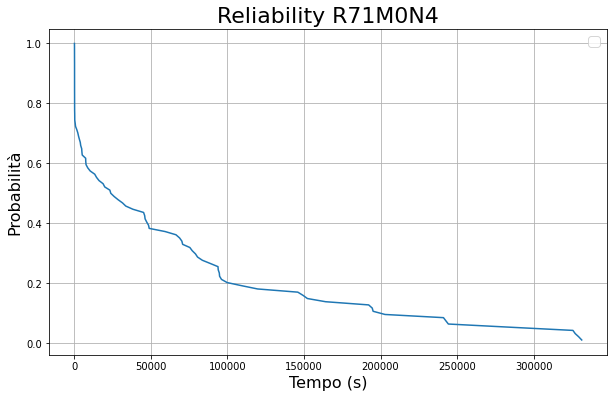

In [64]:
W=50

groups = bluegene_df.groupby('Node')
R71M0N4_tupled = create_tuples(groups.get_group("R71-M0-N4"), W)


R71M0N4_gr = R71M0N4_tupled.groupby('Tuple')

inter = []
t = []

for k,i in R71M0N4_gr: 
    if (k != len(R71M0N4_gr)):
        inter.append(R71M0N4_gr.get_group(k+1)['Timestamp'].min() - R71M0N4_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

R71M0N4_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


R71M0N4_x_rid = np.sort(R71M0N4_interarrivals_df.Interarrivals)
R71M0N4_x_rid = [i for i in  R71M0N4_x_rid if i <=  0.6e6]
R71M0N4_y = np.arange(len(R71M0N4_x_rid))/float(len(R71M0N4_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(R71M0N4_x_rid,1-R71M0N4_y)
plt.title('Reliability R71M0N4', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


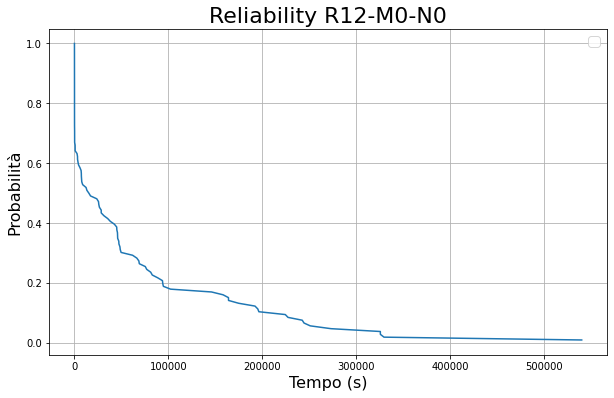

In [65]:
W=50

groups = bluegene_df.groupby('Node')
R12M0N0_tupled = create_tuples(groups.get_group("R12-M0-N0"), W)


R12M0N0_gr = R12M0N0_tupled.groupby('Tuple')

inter = []
t = []

for k,i in R12M0N0_gr: 
    if (k != len(R12M0N0_gr)):
        inter.append(R12M0N0_gr.get_group(k+1)['Timestamp'].min() - R12M0N0_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

R12M0N0_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


R12M0N0_x_rid = np.sort(R12M0N0_interarrivals_df.Interarrivals)
R12M0N0_x_rid = [i for i in  R12M0N0_x_rid if i <=  0.6e6]
R12M0N0_y = np.arange(len(R12M0N0_x_rid))/float(len(R12M0N0_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(R12M0N0_x_rid,1-R12M0N0_y)
plt.title('Reliability R12-M0-N0', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


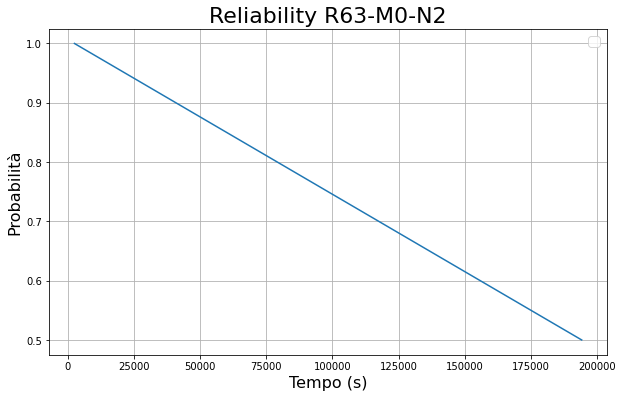

In [66]:
W=50

groups = bluegene_df.groupby('Node')
R63M0N2_tupled = create_tuples(groups.get_group("R63-M0-N2"), W)


R63M0N2_gr = R63M0N2_tupled.groupby('Tuple')

inter = []
t = []

for k,i in R63M0N2_gr: 
    if (k != len(R63M0N2_gr)):
        inter.append(R63M0N2_gr.get_group(k+1)['Timestamp'].min() - R63M0N2_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

R63M0N2_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


R63M0N2_x_rid = np.sort(R63M0N2_interarrivals_df.Interarrivals)
R63M0N2_x_rid = [i for i in  R63M0N2_x_rid if i <=  0.6e6]
R63M0N2_y = np.arange(len(R63M0N2_x_rid))/float(len(R63M0N2_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(R63M0N2_x_rid,1-R63M0N2_y)
plt.title('Reliability R63-M0-N2', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


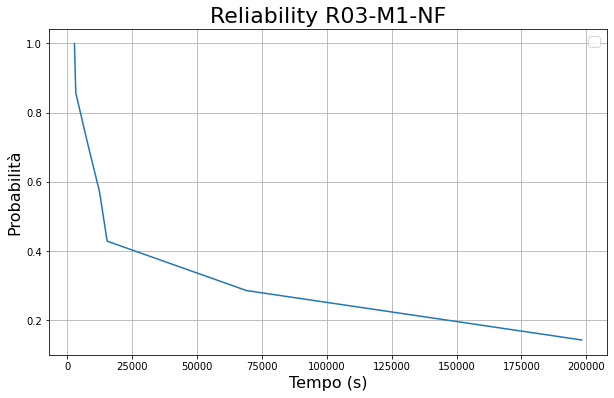

In [67]:
W=50

groups = bluegene_df.groupby('Node')
R03M1NF_tupled = create_tuples(groups.get_group("R03-M1-NF"), W)


R03M1NF_gr = R03M1NF_tupled.groupby('Tuple')

inter = []
t = []

for k,i in R03M1NF_gr: 
    if (k != len(R03M1NF_gr)):
        inter.append(R03M1NF_gr.get_group(k+1)['Timestamp'].min() - R03M1NF_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

R03M1NF_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


R03M1NF_x_rid = np.sort(R03M1NF_interarrivals_df.Interarrivals)
R03M1NF_x_rid = [i for i in  R03M1NF_x_rid if i <=  0.6e6]
R03M1NF_y = np.arange(len(R03M1NF_x_rid))/float(len(R03M1NF_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(R03M1NF_x_rid,1-R03M1NF_y)
plt.title('Reliability R03-M1-NF', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No handles with labels found to put in legend.


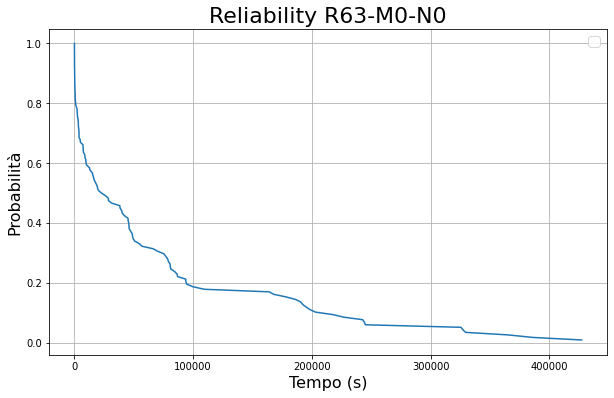

In [68]:
W=100

groups = bluegene_df.groupby('Node')
R63M0N0_tupled = create_tuples(groups.get_group("R63-M0-N0"), W)


R63M0N0_gr = R63M0N0_tupled.groupby('Tuple')

inter = []
t = []

for k,i in R63M0N0_gr: 
    if (k != len(R63M0N0_gr)):
        inter.append(R63M0N0_gr.get_group(k+1)['Timestamp'].min() - R63M0N0_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

R63M0N0_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


R63M0N0_x_rid = np.sort(R63M0N0_interarrivals_df.Interarrivals)
R63M0N0_x_rid = [i for i in  R63M0N0_x_rid if i <= 0.6e6]
R63M0N0_y = np.arange(len(R63M0N0_x_rid))/float(len(R63M0N0_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(R63M0N0_x_rid,1-R63M0N0_y)
plt.title('Reliability R63-M0-N0', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

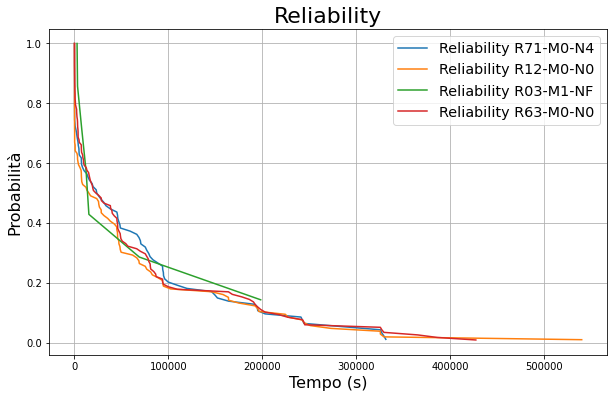

In [69]:
plt.figure(figsize = (10, 6))
plt.plot(R71M0N4_x_rid,1-R71M0N4_y, label="Reliability R71-M0-N4")
plt.plot(R12M0N0_x_rid,1-R12M0N0_y, label="Reliability R12-M0-N0")
# plt.plot(R63M0N2_x_rid,1-R63M0N2_y, label="Reliability R63-M0-N2")
plt.plot(R03M1NF_x_rid,1-R03M1NF_y, label="Reliability R03-M1-NF")
plt.plot(R63M0N0_x_rid,1-R63M0N0_y, label="Reliability R63-M0-N0")

plt.title('Reliability', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.legend(loc='upper right',fontsize = 'x-large')
plt.grid()
plt.show()

### Reliability per CIOD??

In [70]:
bluegene_ciod = bluegene_df[bluegene_df.Message.str.contains("ciod:")]

File già esistente! Caricamento file...
   win_dim  num_tuples
0        1         502
1       21         294
2       41         280
3       61         276
4       81         242
5      101         240
6      121         237
7      141         234
8      161         233
9      181         230


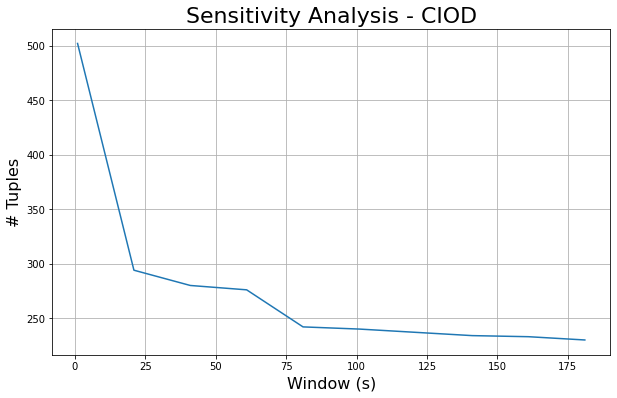

In [71]:
win_range = range(1, 201, 20)


sens_an_df_err = tupling(bluegene_ciod, path+'/sensitivity_analysis_ciod.csv', win_range)
print(sens_an_df_err)
plt.figure(figsize = (10, 6))
plt.plot(sens_an_df_err.win_dim, sens_an_df_err.num_tuples)
plt.title('Sensitivity Analysis - CIOD', size=22)
plt.xlabel('Window (s)', size=16)
plt.ylabel('# Tuples', size=16)
plt.grid()
plt.show()

W= 21 # tuple=294 

<ipython-input-11-3d4d9e53a53c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



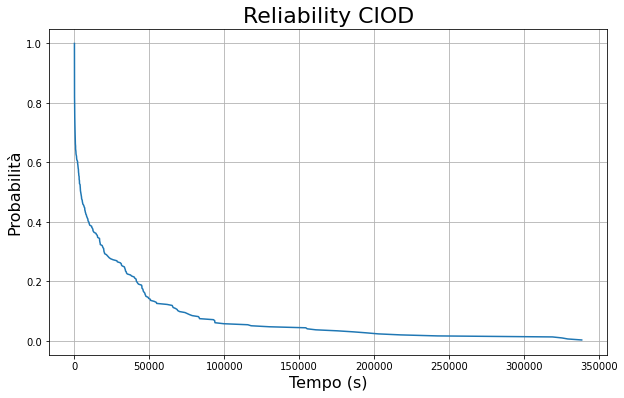

In [72]:
W=21

ciod_tupled = create_tuples(bluegene_ciod, W)


ciod_gr = ciod_tupled.groupby('Tuple')

inter = []
t = []

for k,i in ciod_gr: 
    if (k != len(ciod_gr)):
        inter.append(ciod_gr.get_group(k+1)['Timestamp'].min() - ciod_gr.get_group(k)['Timestamp'].max())
        t.append('Tuple '+str(k)+'-'+str(k+1))

ciod_interarrivals_df = pd.DataFrame({'Tuples' : t, 'Interarrivals' : inter})


ciod_x_rid = np.sort(ciod_interarrivals_df.Interarrivals)
# ciod_x_rid = [i for i in  ciod_x_rid if i <= 0.6e6]
ciod_y = np.arange(len(ciod_x_rid))/float(len(ciod_x_rid))

plt.figure(figsize = (10, 6))
plt.plot(ciod_x_rid,1-ciod_y)
plt.title('Reliability CIOD', size=22)
plt.xlabel('Tempo (s)', size=16)
plt.ylabel('Probabilità', size=16)
plt.grid()
plt.show()